In [1]:
import pandas as pd
import locale

In [2]:
import datetime

# config later to be placed in hydra

days_to_predict = 7
rolling_days = 7
short_lag = 7
long_lag = 14

first_traing_date = datetime.date(2022, 1, 1)

In [3]:
oil = pd.read_csv('../data/raw/oil_prices.csv')
oil

,Date,Price,Open,High,Low,Vol.,Change %
0,09/20/2023,93.09,94.50,94.54,92.77,NaN,-1.32%
1,09/19/2023,94.34,94.66,95.96,94.16,403.40K,-0.10%
2,09/18/2023,94.43,94.28,94.95,93.79,337.78K,0.53%
3,09/15/2023,93.93,94.02,94.63,92.67,316.90K,0.25%
4,09/14/2023,93.70,92.04,94.21,92.02,310.00K,1.98%
...,...,...,...,...,...,...,...
1215,01/08/2019,58.72,57.64,58.87,57.13,288.25K,2.42%
1216,01/07/2019,57.33,57.41,58.93,57.26,296.58K,0.47%
1217,01/04/2019,57.06,55.67,58.31,55.34,321.11K,1.98%
1218,01/03/2019,55.95,54.29,56.30,53.93,278.36K,1.89%


In [4]:
conversions = pd.read_csv('../data/raw/eur_usd_conversions.csv')
conversions

,Date,Price,Open,High,Low,Vol.,Change %
0,09/20/2023,1.0696,1.0680,1.0700,1.0673,NaN,0.18%
1,09/19/2023,1.0677,1.0687,1.0718,1.0674,NaN,-0.12%
2,09/18/2023,1.0690,1.0663,1.0699,1.0654,NaN,0.33%
3,09/15/2023,1.0655,1.0639,1.0689,1.0632,NaN,0.13%
4,09/14/2023,1.0641,1.0729,1.0753,1.0631,NaN,-0.81%
...,...,...,...,...,...,...,...
1227,01/07/2019,1.1476,1.1392,1.1485,1.1392,NaN,0.71%
1228,01/04/2019,1.1395,1.1393,1.1422,1.1345,NaN,0.01%
1229,01/03/2019,1.1394,1.1345,1.1413,1.1309,NaN,0.45%
1230,01/02/2019,1.1343,1.1464,1.1499,1.1325,NaN,-1.06%


In [5]:
def merge_oil_conversions(oil, conversions):
    df = pd.merge(oil, conversions.add_suffix('_USD'), left_on='Date', right_on='Date_USD')
    df['Oil'] = df['Price'] / df['Price_USD']
    df.Date = pd.to_datetime(df.Date)
    df = df.rename(columns={'Price_USD': 'EUR_USD', 'Price': 'Oil_USD'})
    df = df[['Oil', 'Oil_USD', 'EUR_USD', 'Date']]
    df['Oil'] = df['Oil'].apply(lambda x: round(x, 2))
    df.set_index('Date', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    return df

In [6]:
df = merge_oil_conversions(oil, conversions)

In [7]:
df

,Oil,Oil_USD,EUR_USD
Date,,,
2019-01-02,48.41,54.91,1.1343
2019-01-03,49.10,55.95,1.1394
2019-01-04,50.07,57.06,1.1395
2019-01-07,49.96,57.33,1.1476
2019-01-08,51.32,58.72,1.1442
...,...,...,...
2023-09-14,88.06,93.70,1.0641
2023-09-15,88.16,93.93,1.0655
2023-09-18,88.33,94.43,1.0690


In [7]:
import os
import cbsodata

In [8]:
def get_cbs_data(dataset, cache=True):
    cache_dir = '../data/raw/cbs_cache'

    cache_file = os.path.join(cache_dir,dataset+".pickle")
    if cache and os.path.exists(cache_file):
        ds = pd.read_pickle(cache_file)
    else:
        ds = pd.DataFrame(cbsodata.get_data(dataset))
        for c in ds.columns:
            if ds[c].dtype.str == '|O':
                ds[c] = ds[c].str.strip()
        ds.to_pickle(cache_file)

    cache_file2 = os.path.join(cache_dir,dataset+"_info.pickle")
    if cache and os.path.exists(cache_file2):
        columninfo = pd.read_pickle(cache_file2)
    else:
        columninfo = pd.DataFrame(cbsodata.get_meta(dataset, 'DataProperties'))
        columninfo.to_pickle(cache_file2)
    return ds, columninfo

In [9]:
fuel , _ = get_cbs_data("80416ned")
fuel

,ID,Perioden,BenzineEuro95_1,Diesel_2,Lpg_3
0,0,2006 zondag 1 januari,1.325,1.003,0.543
1,1,2006 maandag 2 januari,1.328,1.007,0.542
2,2,2006 dinsdag 3 januari,1.332,1.007,0.540
3,3,2006 woensdag 4 januari,1.348,1.020,0.550
4,4,2006 donderdag 5 januari,1.347,1.021,0.550
...,...,...,...,...,...
6458,6458,2023 donderdag 7 september,2.097,1.861,0.751
6459,6459,2023 vrijdag 8 september,2.096,1.864,0.761
6460,6460,2023 zaterdag 9 september,2.101,1.875,0.761
6461,6461,2023 zondag 10 september,2.104,1.877,0.756


In [10]:
def process_cbs_data(df):
    day_of_week = {
    "zondag": "Sunday",
    "maandag": "Monday",
    "dinsdag": "Tuesday",
    "woensdag": "Wednesday",
    "donderdag": "Thursday",
    "vrijdag": "Friday",
    "zaterdag": "Saturday"
    }

    months = {
        "januari": "January",
        "februari": "February",
        "maart": "March",
        "april": "April",
        "mei": "May",
        "juni": "June",
        "juli": "July",
        "augustus": "August",
        "september": "September",
        "oktober": "October",
        "november": "November",
        "december": "December"	
    }

    # replace any value of day_of_week and months with the english version in df["Perioden"]
    df["Perioden"] = df["Perioden"].replace(day_of_week, regex=True)
    df["Perioden"] = df["Perioden"].replace(months, regex=True)
    
    df['Perioden'] = pd.to_datetime(df["Perioden"])

    df.drop(['ID', 'Diesel_2', 'Lpg_3'], axis=1, inplace=True)

    df.rename(columns={'BenzineEuro95_1': 'Eu95', 'Perioden': 'Date'}, inplace=True)
    df.set_index('Date', inplace=True)

    return df

In [11]:
fuel = process_cbs_data(fuel)

In [12]:
fuel

,Eu95
Date,
2006-01-01,1.325
2006-01-02,1.328
2006-01-03,1.332
2006-01-04,1.348
2006-01-05,1.347
...,...
2023-09-07,2.097
2023-09-08,2.096
2023-09-09,2.101


In [13]:
df

,Oil,Oil_USD,EUR_USD
Date,,,
2019-01-02,48.41,54.91,1.1343
2019-01-03,49.10,55.95,1.1394
2019-01-04,50.07,57.06,1.1395
2019-01-07,49.96,57.33,1.1476
2019-01-08,51.32,58.72,1.1442
...,...,...,...
2023-09-14,88.06,93.70,1.0641
2023-09-15,88.16,93.93,1.0655
2023-09-18,88.33,94.43,1.0690


In [14]:
df = pd.merge(df, fuel, on='Date', how='outer').sort_index(ascending=True)

In [15]:
df

,Oil,Oil_USD,EUR_USD,Eu95
Date,,,,
2006-01-01,NaN,NaN,NaN,1.325
2006-01-02,NaN,NaN,NaN,1.328
2006-01-03,NaN,NaN,NaN,1.332
2006-01-04,NaN,NaN,NaN,1.348
2006-01-05,NaN,NaN,NaN,1.347
...,...,...,...,...
2023-09-14,88.06,93.70,1.0641,NaN
2023-09-15,88.16,93.93,1.0655,NaN
2023-09-18,88.33,94.43,1.0690,NaN


In [16]:
import datetime

def get_test_dates():
    today = datetime.date.today()
    idx = (today.weekday() + 1) % 7
    # to make sure you get enough time to predict the next 14 days and skip the furthest lag of smoothing
    # 7 is added because it takes a week before the data is uploaded to CBS
    begin = today - datetime.timedelta(idx + days_to_predict + long_lag - 1)
    # to predict until the Sunday available on the website
    end = today - datetime.timedelta(idx+7)

    return begin, end

In [17]:
def preprocess(df):
    df = df.resample('1d').max().interpolate()
    df.dropna(inplace=True)
    df['Oil_smoothed'] = df['Oil'].rolling(rolling_days).mean()
    df['Oil_smoothed'].apply(lambda x: round(x, 3))
    df['Eu95_smoothed'] = df['Eu95'].rolling(rolling_days).mean()
    df['Eu95_smoothed'].apply(lambda x: round(x, 3))
    df['EUR_USD'].apply(lambda x: round(x, 3))

    df['Oil_short_lag'] = df['Oil_smoothed'].shift(days_to_predict)
    df['Oil_long_lag'] = df['Oil_smoothed'].shift(short_lag + days_to_predict)
    df['Oil_delta'] = df['Oil_long_lag'] - df['Oil_short_lag']

    df['Eu95_short_lag'] = df['Eu95_smoothed'].shift(days_to_predict)
    df['Eu95_long_lag'] = df['Eu95_smoothed'].shift(short_lag + days_to_predict)
    df['Eu95_delta'] = df['Eu95_long_lag'] - df['Eu95_short_lag']

    features = ['Oil_short_lag', 'Oil_long_lag', 'Oil_delta', 'Eu95_short_lag', 'Eu95_long_lag', 'Eu95_delta']
    target = 'Eu95'

    X = df[features]
    y = df[target]

    return X, y

In [18]:
X, y = preprocess(df)

In [19]:
def split_train_test(X, y):
    begin, end = get_test_dates()
    X_train = X[:begin - datetime.timedelta(days=1)]
    y_train = y[:begin - datetime.timedelta(days=1)]
    X_train = X_train.loc[first_traing_date:]
    y_train = y_train.loc[first_traing_date:]

    X_test = X[begin + datetime.timedelta(days=rolling_days):end]
    y_test = y[begin + datetime.timedelta(days=rolling_days):end]
    
    return X_train, y_train, X_test, y_test

In [20]:
X_train, y_train, X_test, y_test = split_train_test(X, y)

In [ ]:
import pickle

with open('../data/processed/X_y_data.pickle', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

In [470]:
# ax = df['Oil'].plot(legend=True, figsize=(15,5))
# ax.set_ylabel('Oil price')
# ax = df[['Eu95']].plot(secondary_y=True, ax=ax, legend=True)
# ax.set_title('Oil and Eu95 prices over time')
# _ = ax.set_ylabel('Eu95 price')

In [471]:
# ax = df['Oil'][df.index.year == 2022].plot(legend=True, figsize=(15,5))
# ax.set_ylabel('Oil price')
# ax = df[['Eu95']][df.index.year == 2022].plot(secondary_y=True, ax=ax, legend=True)
# ax.set_title('Oil and Eu95 prices over time')
# _ = ax.set_ylabel('Eu95 price')

In [472]:
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5, gap=7)

date_column = []
prediction_column = []
true_column = []
scores = []

for train_idx, val_idx in tscv.split(X=X_train, y=y_train):
    model = sm.OLS(y_train.iloc[train_idx], X_train.iloc[train_idx]).fit()
    # Score the model
    dates = X_train.iloc[val_idx].index
    date_column.extend(dates)
    predictions = model.predict(X_train.iloc[val_idx])
    predictions = [round(x, 3) for x in predictions]
    prediction_column.extend(predictions)
    true_column.extend(y_train.iloc[val_idx])
    rmse = mean_squared_error(y_train.iloc[val_idx], predictions, squared=False)
    scores.append(rmse)

prediction_table = pd.DataFrame({'date': date_column, 'prediction': prediction_column, 'true': true_column}).set_index('date')
score = sum(scores) / len(scores)
print(f"Average RMSE: {score:.3f}")
print(f"Scores per fold: {[round(x, 3) for x in scores]}")

Average RMSE: 0.044
Scores per fold: [0.066, 0.032, 0.043, 0.033, 0.044]


In [473]:
final_model = sm.OLS(y_train, X_train).fit()
# Score the model
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds, squared=False)
print(rmse)

0.0177692618463025


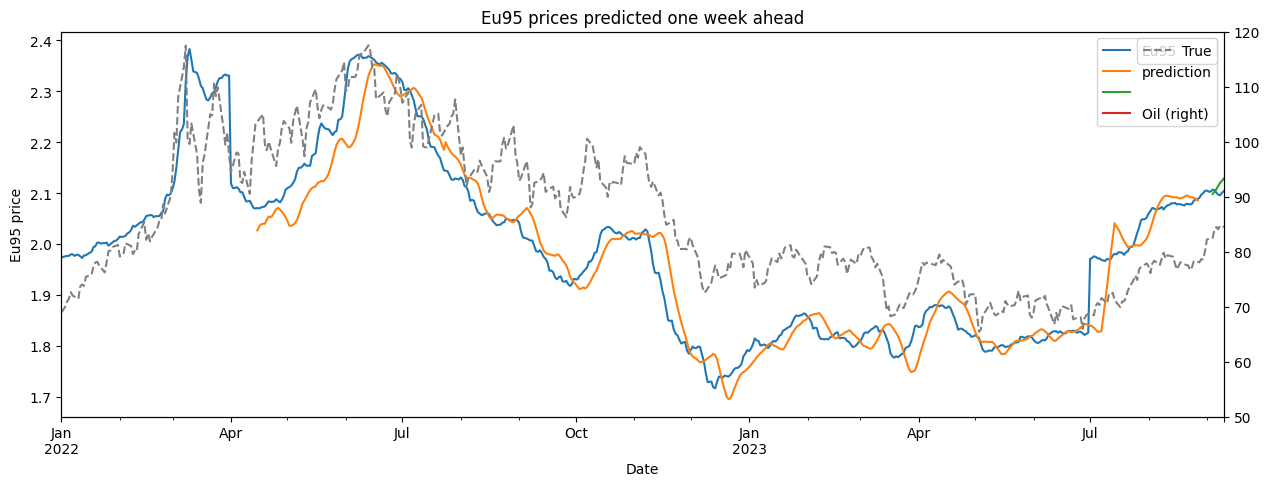

In [475]:
begin_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2023, 9, 10)

# plot df['Eu95'] as the main graph, and then plot 'preds' as a line on top of it
ax = df[['Eu95']].loc[begin_date:end_date].plot(legend=True, figsize=(15,5))
ax.set_ylabel('Eu95 price')
ax = prediction_table['prediction'].plot(secondary_y=False, ax=ax, legend=True)
ax = preds.plot(secondary_y=False, ax=ax, legend=True)
ax.set_title('Eu95 prices predicted one week ahead')
_ = ax.set_ylabel('Eu95 price')

# add oil prices to the graph
ax = df[['Oil']].resample('1d').max().interpolate().loc[begin_date:end_date].plot(secondary_y=True, ax=ax, legend=True)

# set oil price y axis from 50 to 120
ax.set_ylim([50, 120])

# set oil price graph to background and dotted
ax.get_lines()[0].set_linestyle("--")
ax.get_lines()[0].set_color("grey")

# set labels of all three graphs
ax.legend(['True', 'Prediction (val)', 'Prediction (test)'])
